In [48]:
%reset -sf

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import ortools
import networkx as nx
import graph_tool
import graph_tool.draw

# Input parsing

In [50]:
case_a = "a_an_example.in.txt"
case_b = "b_basic.in.txt"
case_c = "c_coarse.in.txt"
case_d = "d_difficult.in.txt"
case_e = "e_elaborate.in.txt"

folder_in = "input_data/"
folder_out = "output/"

In [51]:
cases = [case_a, case_b, case_c, case_d, case_e]

In [52]:
case = case_a
case = case_b
case = case_c
# case = case_d
# case = case_e

In [53]:
with open(folder_in + case) as f:
    srr = [row.strip() for row in f.readlines()]
    
    arr = [set(x.split()[1:]) for x in srr[1::2]]
    brr = [set(x.split()[1:]) for x in srr[2::2]]

In [54]:
aset = set().union(*arr)
bset = set().union(*brr)
allset = aset | bset

In [55]:
always_include = aset - bset
always_exclude = bset - aset
to_decide = allset - always_include - always_exclude

len(always_include), len(always_exclude), len(to_decide)

(4, 1, 5)

In [56]:
xrr = [x & to_decide for x in arr]
yrr = [x & to_decide for x in brr]

# Data analysis

In [57]:
from collections import Counter
in_counter = Counter()
out_counter = Counter()

for x,y in zip(xrr, yrr):
    in_counter += Counter(x)
    out_counter += Counter(y)

In [58]:
xcount = []
ycount = []
for x in to_decide:
    xcount.append(in_counter[x])
    ycount.append(out_counter[x])

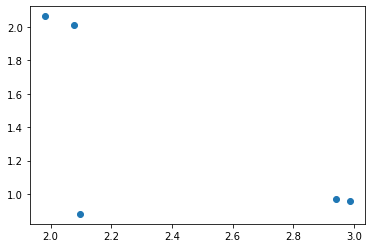

In [59]:
# each datapoint is an ingredient
# x is how many times it is included by a customer
# y is how many times it is excluded by a customer
length = len(xcount)
plt.scatter(np.array(xcount) + np.random.randn(length)/10, 
            np.array(ycount) + np.random.randn(length)/10)
plt.show()

In [60]:
# analyse which pairs of customers cannot be served together
# you can only select customers that are not connected by a vertex

In [61]:
# G = nx.DiGraph()

# for i,(xr1,yr1) in enumerate(zip(xrr, yrr)):
#     G.add_node(i)
#     for j,(xr2,yr2) in enumerate(zip(xrr[i+1:], yrr[i+1:]), start=i+1):
#         if xr1 & yr2 or xr2 & yr1:
#             G.add_edge(i,j)
            
# too slow
# nx.draw(G)

In [62]:
# https://graph-tool.skewed.de/static/doc/quickstart.html
G = graph_tool.Graph(directed=False)
G.add_vertex(len(xrr))

for i,(xr1,yr1) in enumerate(zip(xrr, yrr)):
    for j,(xr2,yr2) in enumerate(zip(xrr[i+1:], yrr[i+1:]), start=i+1):
        if xr1 & yr2 or xr2 & yr1:
            G.add_edge(i,j)

# too slow
# nx.draw(G)

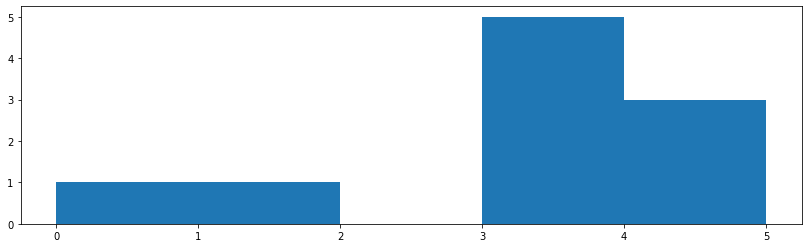

In [63]:
plt.figure(figsize=(14,4))
degrees = G.get_total_degrees(G.get_vertices())
plt.hist(degrees, bins=range(0, int(max(degrees)) + 2))
plt.show()

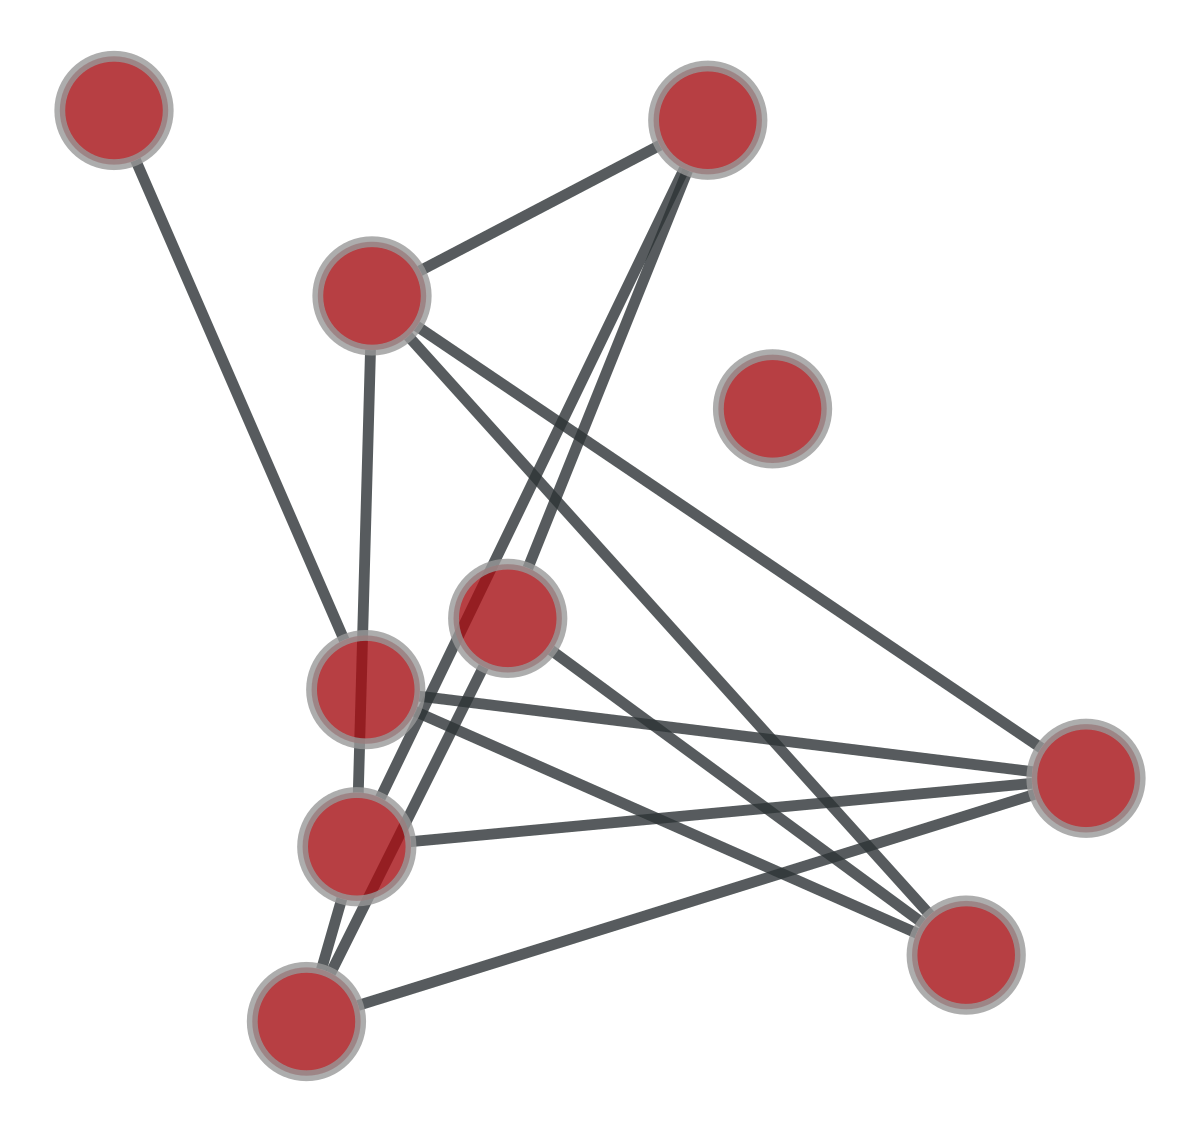

In [68]:
# pretty messy when large

# pos = graph_tool.draw.random_layout(G)
graph_tool.draw.graph_draw(G, pos=pos)
plt.show()

# Upper bound analysis

In [69]:
# see Codeforces comment
# probably not gonna do for this practice
# also unlikely to do such complicated analysis in qualifiers

# Scoring

In [70]:
def scoring(crr):
    crr = set(crr)
    res = 0
    for a,b in zip(arr,brr):
        
        all_included = set(a) & crr == set(a)
        all_excluded = set(b) & crr == set()

        if all_included and all_excluded:
            res += 1
    return res

scoring(list(always_include))

1

In [71]:
res = list(always_include)

# Submission

In [72]:
import shutil

def save_file(res):
    shutil.copy("notebook_adhoc.ipynb", folder_out)
    score = str(scoring(res)).zfill(10)
    with open(folder_out + case + score, "w") as f:
        f.write(str(len(res)) + " " + " ".join(res))
        
save_file(res)

# 1-opt

Idea - force to serve a customer

In [73]:
!ls output

c_coarse.in.txt0000000001    e_elaborate.in.txt0000000412
c_coarse.in.txt0000000005    e_elaborate.in.txt0000001648
d_difficult.in.txt0000001420 e_elaborate.in.txt0000001653
d_difficult.in.txt0000001707 e_elaborate.in.txt0000001686
d_difficult.in.txt0000001786 e_elaborate.in.txt0000001806
d_difficult.in.txt0000001790 e_elaborate.in.txt0000001813
d_difficult.in.txt0000001791 e_elaborate.in.txt0000001819
d_difficult.in.txt0000001792 notebook_adhoc.ipynb


In [76]:
# initialisation
crr = always_include

In [75]:
# loads an input

score = '0000001806'
filename = case + score
with open(folder_out + case + score) as f:
    crr = f.read().split()[1:]

FileNotFoundError: [Errno 2] No such file or directory: 'output/c_coarse.in.txt0000001806'

In [77]:
prev_points, pts = scoring(crr), 0
crr = set(crr)

while True:
    idx = np.random.randint(0,len(xrr)-1)
    
    if xrr[idx] & crr == xrr[idx] and not yrr[idx] & crr:
        continue
    new_crr = (crr | xrr[idx]) - yrr[idx]
    
    pts = scoring(new_crr)
    if pts > prev_points:
        crr = new_crr
        prev_points = pts
        print(pts)

4
5


KeyboardInterrupt: 

In [46]:
res = crr
save_file(res)

# 2-opt
Force to serve two customers

In [78]:
crr = set(crr)
prev_points, pts = scoring(crr), 0
# del idx

while True:
    idx1 = np.random.randint(0,len(xrr)-1)
    idx2 = np.random.randint(0,len(xrr)-1)
    
    if xrr[idx1] & yrr[idx2]:
        continue
    if xrr[idx2] & yrr[idx1]:
        continue
    if xrr[idx1] & crr == xrr[idx1] and not yrr[idx1] & crr:
        continue
    if xrr[idx2] & crr == xrr[idx2] and not yrr[idx2] & crr:
        continue
    
    new_crr = (crr | xrr[idx1] | xrr[idx2]) - yrr[idx1] - yrr[idx2]
    
    pts = scoring(new_crr)
    if pts > prev_points:
        crr = new_crr
        prev_points = pts
        print(pts)

KeyboardInterrupt: 

In [79]:
res = crr
save_file(res)

# Integer Programming
Likely totally useless in actual contest.

In [80]:
from ortools.linear_solver import pywraplp
solver = pywraplp.Solver.CreateSolver('SCIP')


In [81]:
ingredients = {x:solver.IntVar(0, 1, x) for x in to_decide}

targets = []
for i,(xr,yr) in enumerate(zip(xrr, yrr)):
    satisfied = solver.IntVar(0, 1, str(i).zfill(6))
    
    # all included ingredients
    if xr:
        solver.Add(len(xr) - sum(ingredients[x] for x in xr) <= (1 - satisfied) * (len(xr)))
    
    # all excluded ingredients 
    if yr:
        solver.Add(sum(ingredients[y] for y in yr) <= (1 - satisfied) * (len(yr)))
    targets.append(satisfied)

solver.SetTimeLimit(2*60*60*1000)
solver.Maximize(sum(targets))

In [82]:
status = solver.Solve()

In [83]:
if status == pywraplp.Solver.OPTIMAL:
    print('Solution:')
    print('Objective value =', solver.Objective().Value())
else:
    print('The problem does not have an optimal solution.')

print('\nAdvanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations' % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())

Solution:
Objective value = 5.0

Advanced usage:
Problem solved in 1264.000000 milliseconds
Problem solved in 8 iterations
Problem solved in 1 branch-and-bound nodes


In [84]:
res = [k for k,v in ingredients.items() if v.solution_value() == 1]
res = set(res) | always_include

print(scoring(res))
save_file(res)

5
